<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Dependencies

In [1]:
%pip install sktime tsfresh scikit-multilearn;

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

In [3]:
import sktime

In [4]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [5]:
sns.set(font_scale=1.2)

# Dataset download

In [6]:
!wget -nc "https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip"
!unzip -n "data.zip" 

--2022-05-23 11:23:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76601704 (73M) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>]  73.05M  48.8MB/s    in 1.5s    

2022-05-23 11:23:16 (48.8 MB/s) - ‘data.zip’ saved [76601704/76601704]

Archive:  data.zip
  inflating: CE.txt                  
  inflating: CP.txt                  
  inflating: description.txt         
  inflating: EPS1.txt                
  inflating: FS1.txt                 
  inflating: FS2.txt                 
  inflating: profile.txt             
  inflating: PS1.txt                 
  inflating: PS2.txt                 
  inflating: PS3.txt                 
  inflating: PS4.txt                 
  inflating: PS5.txt             


    Pressure sensors (PS1-6): 100 Hz, 6000 attributes per sensor (6 sensors)
    Motor power sensor (EPS1): 100 Hz, 6000 attributes per sensor (1 sensor)
    Volume flow sensors (FS1/2): 10 Hz, 600 attributes per sensor (2 sensors)
    Temperature sensors (TS1-4): 1 Hz, 60 attributes per sensor (4 sensors)
    Vibration sensor (VS1): 1 Hz, 60 attributes per sensor (1 sensor)
    Efficiency factor (SE): 1 Hz, 60 attributes per sensor (1 sensor)
    Virtual cooling efficiency sensor (CE): 1 Hz, 60 attributes per sensor (1 sensor)
    Virtual cooling power sensor (CP): 1 Hz, 60 attributes per sensor (1 sensor)


Two approaches to multivariated time series:
- Extract features and use regular methods
- Use sktime to process the time series themselves


Partial: let's use mean, median and some basic metrics to see the results \\
Final: use a feature extractor

# Data Loading

We have different sample rates, i.e., different amount of samples for some sensors, we must normalize all to 100Hz (?)

In [7]:
all_patterns = ["PS*", "C*", "EPS*", "S*", "TS*", "VS*"]
all_files = []

for pat in all_patterns:
    partial = list(glob.glob(pat))
    all_files += partial
all_files

['PS4.txt',
 'PS1.txt',
 'PS2.txt',
 'PS5.txt',
 'PS6.txt',
 'PS3.txt',
 'CE.txt',
 'CP.txt',
 'EPS1.txt',
 'SE.txt',
 'TS3.txt',
 'TS1.txt',
 'TS4.txt',
 'TS2.txt',
 'VS1.txt']

In [8]:
a=[]
for f in all_files:
    print(f"Reading {f}")
    ts = np.genfromtxt(f)
    nested = from_2d_array_to_nested(ts)
    a.append(nested)
len(a)

Reading PS4.txt
Reading PS1.txt
Reading PS2.txt
Reading PS5.txt
Reading PS6.txt
Reading PS3.txt
Reading CE.txt
Reading CP.txt
Reading EPS1.txt
Reading SE.txt
Reading TS3.txt
Reading TS1.txt
Reading TS4.txt
Reading TS2.txt
Reading VS1.txt


15

In [9]:
for line in a:
    print(line.shape)

(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)
(2205, 1)


In [11]:
new_df = pd.DataFrame()
for i in range(len(a)):
    new_df[all_files[i][:-4]] = a[i]
new_df.head()

,PS4,PS1,PS2,PS5,PS6,PS3,CE,CP,EPS1,SE,TS3,TS1,TS4,TS2,VS1
0,0 0.0 1 0.0 2 0.0 3 0....,0 151.47 1 151.45 2 151.52 3...,0 125.50 1 125.39 2 125.40 3...,0 9.936 1 9.947 2 9.964 3 ...,0 9.818 1 9.823 2 9.844 3 ...,0 2.305 1 2.305 2 2.336 3 ...,0 47.202 1 47.273 2 47.250 3 4...,0 2.184 1 2.184 2 2.184 3 2.18...,0 2411.6 1 2411.6 2 2411.6 3...,0 68.039 1 0.000 2 0.000 3 ...,0 38.320 1 38.332 2 38.320 3 3...,0 35.570 1 35.492 2 35.469 3 3...,0 30.363 1 30.375 2 30.367 3 3...,0 40.961 1 40.949 2 40.965 3 4...,0 0.604 1 0.605 2 0.611 3 0.60...
1,0 0.0 1 0.0 2 0.0 3 0....,0 151.11 1 151.12 2 151.16 3...,0 125.06 1 125.08 2 125.09 3...,0 9.700 1 9.687 2 9.682 3 ...,0 9.592 1 9.573 2 9.578 3 ...,0 2.281 1 2.320 2 2.305 3 ...,0 29.208 1 28.822 2 28.805 3 2...,0 1.414 1 1.384 2 1.385 3 1.38...,0 2409.6 1 2409.6 2 2409.6 3...,0 68.264 1 0.000 2 0.000 3 ...,0 38.680 1 38.672 2 38.668 3 3...,0 36.156 1 36.094 2 35.992 3 3...,0 33.648 1 33.723 2 33.723 3 3...,0 41.258 1 41.277 2 41.262 3 4...,0 0.590 1 0.610 2 0.626 3 0.62...
2,0 0.0 1 0.0 2 0.0 3 0....,0 150.81 1 150.79 2 150.84 3...,0 125.13 1 125.27 2 125.23 3...,0 9.606 1 9.587 2 9.573 3 ...,0 9.505 1 9.484 2 9.476 3 ...,0 2.227 1 2.187 2 2.156 3 ...,0 23.554 1 23.521 2 23.527 3 2...,0 1.159 1 1.157 2 1.157 3 1.13...,0 2397.8 1 2397.8 2 2397.8 3...,0 68.595 1 0.000 2 0.000 3 ...,0 39.234 1 39.246 2 39.246 3 3...,0 37.488 1 37.391 2 37.340 3 3...,0 35.113 1 35.121 2 35.098 3 3...,0 42.129 1 42.105 2 42.117 3 4...,0 0.578 1 0.603 2 0.638 3 0.65...
3,0 0.0 1 0.0 2 0.0 3 0....,0 150.48 1 150.47 2 150.52 3...,0 124.93 1 124.96 2 124.92 3...,0 9.528 1 9.514 2 9.501 3 ...,0 9.422 1 9.415 2 9.394 3 ...,0 2.320 1 2.352 2 2.297 3 ...,0 21.540 1 21.419 2 21.565 3 2...,0 1.101 1 1.086 2 1.107 3 1.07...,0 2383.8 1 2383.8 2 2383.8 3...,0 68.628 1 0.000 2 0.000 3 ...,0 40.086 1 40.047 2 40.102 3 4...,0 38.633 1 38.535 2 38.469 3 3...,0 36.133 1 36.105 2 36.113 3 3...,0 43.039 1 43.043 2 43.039 3 4...,0 0.565 1 0.591 2 0.608 3 0.61...
4,0 0.0 1 0.0 2 0.0 3 0....,0 150.41 1 150.35 2 150.24 3...,0 124.72 1 124.74 2 124.66 3...,0 9.408 1 9.392 2 9.373 3 ...,0 9.315 1 9.296 2 9.287 3 ...,0 2.250 1 2.250 2 2.242 3 ...,0 20.460 1 20.298 2 20.350 3 1...,0 1.086 1 1.081 2 1.087 3 1.06...,0 2372.0 1 2372.0 2 2372.0 3...,0 68.868 1 0.000 2 0.000 3 ...,0 40.934 1 40.922 2 40.922 3 4...,0 39.461 1 39.461 2 39.375 3 3...,0 36.992 1 37.004 2 37.008 3 3...,0 44.031 1 44.027 2 43.988 3 4...,0 0.570 1 0.600 2 0.623 3 0.63...


The target condition values are cycle-wise annotated in â€˜profile.txtâ€˜ (tab-delimited). As before, the row number represents the cycle number. The columns are

    1: Cooler condition / %:
    3: close to total failure
    20: reduced effifiency
    100: full efficiency

    2: Valve condition / %:
    100: optimal switching behavior
    90: small lag
    80: severe lag
    73: close to total failure

    3: Internal pump leakage:
    0: no leakage
    1: weak leakage
    2: severe leakage

    4: Hydraulic accumulator / bar:
    130: optimal pressure
    115: slightly reduced pressure
    100: severely reduced pressure
    90: close to total failure

    5: stable flag:
    0: conditions were stable
    1: static conditions might not have been reached yet

In [12]:
target = np.genfromtxt("profile.txt")

df_temp=pd.DataFrame(target,columns=["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"])
df_temp.head()

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,3.0,100.0,0.0,130.0,1.0
1,3.0,100.0,0.0,130.0,1.0
2,3.0,100.0,0.0,130.0,1.0
3,3.0,100.0,0.0,130.0,1.0
4,3.0,100.0,0.0,130.0,1.0


# EDA

In [14]:
df_temp.value_counts()

Cooler_Condition  Valve_Condition  Internal_Pump_Leakage  Hydraulic_Accumulator  Stable_Flag
100.0             100.0            0.0                    90.0                   1.0            211
3.0               100.0            0.0                    130.0                  1.0            211
20.0              100.0            0.0                    90.0                   1.0            211
100.0             100.0            0.0                    90.0                   0.0             19
20.0              100.0            0.0                    100.0                  1.0             11
                                                                                               ... 
                                   1.0                    130.0                  1.0              1
                                                          115.0                  1.0              1
                                                          100.0                  1.0              1
       

In [15]:
df_temp['Stable_Flag'].value_counts()

0.0    1449
1.0     756
Name: Stable_Flag, dtype: int64

In [19]:
df_temp['Valve_Condition'].value_counts()

0.0    1449
1.0     756
Name: Stable_Flag, dtype: int64

In [20]:
df_temp['Cooler_Condition'].value_counts()

100.0    741
3.0      732
20.0     732
Name: Cooler_Condition, dtype: int64

In [21]:
df_temp['Internal_Pump_Leakage'].value_counts()

0.0    1221
2.0     492
1.0     492
Name: Internal_Pump_Leakage, dtype: int64

In [22]:
df_temp['Hydraulic_Accumulator'].value_counts()

90.0     808
130.0    599
115.0    399
100.0    399
Name: Hydraulic_Accumulator, dtype: int64

Muitos valores estáveis, apesar de uma proporção OK até

In [ ]:
df_temp.value_counts()

Cooler_Condition  Valve_Condition  Internal_Pump_Leakage  Hydraulic_Accumulator  Stable_Flag
100.0             100.0            0.0                    90.0                   1.0            211
3.0               100.0            0.0                    130.0                  1.0            211
20.0              100.0            0.0                    90.0                   1.0            211
100.0             100.0            0.0                    90.0                   0.0             19
20.0              100.0            0.0                    100.0                  1.0             11
                                                                                               ... 
                                   1.0                    130.0                  1.0              1
                                                          115.0                  1.0              1
                                                          100.0                  1.0              1
       

## PCA

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Processing

In [34]:
from sktime.datatypes._panel._convert import from_nested_to_2d_array

concatenated = from_nested_to_2d_array(new_df)
concatenated.head()

,PS4__0,PS4__1,PS4__2,PS4__3,PS4__4,PS4__5,PS4__6,PS4__7,PS4__8,PS4__9,...,VS1__50,VS1__51,VS1__52,VS1__53,VS1__54,VS1__55,VS1__56,VS1__57,VS1__58,VS1__59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.554,0.552,0.545,0.553,0.553,0.539,0.544,0.545,0.535,0.543
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.555,0.547,0.548,0.544,0.536,0.542,0.540,0.533,0.531,0.534
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.543,0.544,0.543,0.554,0.544,0.544,0.545,0.544,0.530,0.534
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.549,0.538,0.553,0.543,0.553,0.555,0.544,0.543,0.543,0.542
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.546,0.546,0.544,0.552,0.539,0.540,0.549,0.542,0.533,0.537


In [37]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
concatenated_fitted = sc.fit_transform(concatenated)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(concatenated_fitted)

In [44]:
pca_df = pd.DataFrame(data=principalComponents, columns=['x','y'])
pca_df = pd.concat([pca_df, df_temp['Stable_Flag']], axis = 1)
pca_df.head()

,x,y,Stable_Flag
0,-127.474739,5.064382,1.0
1,-102.101283,-4.710304,1.0
2,-82.167823,-13.332755,1.0
3,-63.378624,-18.344136,1.0
4,-47.933184,-23.878605,1.0


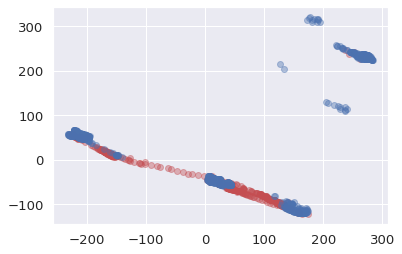

In [56]:
plt.scatter(pca_df[pca_df.Stable_Flag == 1]['x'], pca_df[pca_df.Stable_Flag == 1]['y'], c='r', alpha=0.4, label='Stable')
plt.scatter(pca_df[pca_df.Stable_Flag == 0]['x'], pca_df[pca_df.Stable_Flag == 0]['y'], c='b', alpha=0.4, label='Stability not reached')

In [45]:
targets = [0, 1]
colors = ['r', 'g']
classes = ['Stable', 'Stability not reached']
for t, c in zip(targets,colors):
    keep = (pca_df.Class == t)
    plt.scatter(pca_df.loc[keep, 'x'], pca_df.loc[keep, 'y'], c=c, label=classes[t])

AttributeError: ignored

In [31]:
u_PS1 = from_nested_to_2d_array(new_df['PS1'])
u_PS2 = from_nested_to_2d_array(new_df['PS2'])
u_PS2 = from_nested_to_2d_array(new_df['PS2'])

pd.concat([unnested_PS1, unnested_PS2], axis=1)

,PS1__0,PS1__1,PS1__2,PS1__3,PS1__4,PS1__5,PS1__6,PS1__7,PS1__8,PS1__9,...,PS2__5990,PS2__5991,PS2__5992,PS2__5993,PS2__5994,PS2__5995,PS2__5996,PS2__5997,PS2__5998,PS2__5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,125.02,125.00,125.10,125.09,124.98,124.91,124.98,125.11,125.14,125.10
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,124.80,124.88,125.13,125.22,125.09,124.98,125.06,125.13,125.09,125.04
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,124.61,124.69,124.74,124.71,124.59,124.64,124.74,124.73,124.77,124.88
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,124.82,124.79,124.69,124.69,124.77,124.83,124.69,124.53,124.51,124.59
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,124.80,124.67,124.49,124.56,124.69,124.62,124.45,124.41,124.47,124.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,151.70,151.83,151.90,151.75,151.62,151.63,153.78,154.73,153.83,154.43,...,125.57,125.51,125.38,125.43,125.59,125.61,125.53,125.50,125.60,125.73
2201,151.90,151.83,151.81,151.77,151.65,151.63,153.97,154.84,153.67,154.37,...,125.86,125.77,125.74,125.81,125.77,125.66,125.58,125.58,125.55,125.44
2202,151.73,151.78,151.84,151.62,151.46,151.49,153.91,154.88,153.69,154.24,...,125.66,125.73,125.77,125.81,125.94,126.04,125.98,125.84,125.84,125.94
2203,151.77,151.77,151.75,151.56,151.47,151.57,154.09,154.80,153.45,154.21,...,125.55,125.56,125.58,125.74,125.84,125.73,125.66,125.73,125.86,125.91


In [ ]:
from sktime.datatypes._panel._convert import from_nested_to_2d_array

def extract(col, dest_df):
    unnested = from_nested_to_2d_array(new_df[col])
    dest_df[col+"_mean"] = unnested.mean(axis=1)
    dest_df[col+"_min"] = unnested.min(axis=1)
    dest_df[col+"_max"] = unnested.max(axis=1)
    dest_df[col+"_std"] = unnested.std(axis=1)

In [ ]:
extracted_df = pd.DataFrame()
for col in new_df.columns:
    extract(col, extracted_df)

In [ ]:
extracted_df.head()

,PS4_mean,PS4_min,PS4_max,PS4_std,PS1_mean,PS1_min,PS1_max,PS1_std,PS2_mean,PS2_min,...,TS4_max,TS4_std,TS2_mean,TS2_min,TS2_max,TS2_std,VS1_mean,VS1_min,VS1_max,VS1_std
0,0.0,0.0,0.0,0.0,160.673492,145.83,191.51,13.939309,109.466914,0.0,...,33.594,1.116478,40.978767,40.773,41.250,0.154302,0.576950,0.532,0.624,0.027078
1,0.0,0.0,0.0,0.0,160.603320,145.73,191.47,14.118967,109.354890,0.0,...,35.148,0.435312,41.532767,41.031,42.105,0.338234,0.565850,0.524,0.626,0.027241
2,0.0,0.0,0.0,0.0,160.347720,145.37,191.41,14.192619,109.158845,0.0,...,36.141,0.293889,42.442450,41.832,43.039,0.390588,0.576533,0.529,0.662,0.036729
3,0.0,0.0,0.0,0.0,160.188088,145.14,191.34,14.227803,109.064807,0.0,...,36.988,0.262397,43.403983,42.805,43.988,0.398476,0.569267,0.527,0.645,0.033464
4,0.0,0.0,0.0,0.0,160.000472,144.95,191.41,14.276434,108.931434,0.0,...,37.781,0.239571,44.332750,43.742,44.887,0.372769,0.577367,0.524,0.660,0.033484


# Training

In [ ]:
X = extracted_df
y = df_temp

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y['Stable_Flag'],
                                                    stratify=y['Stable_Flag'], 
                                                    test_size=0.25)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1653, 60), (1653,), (552, 60), (552,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.score(X_train,y_train)

0.9764065335753176

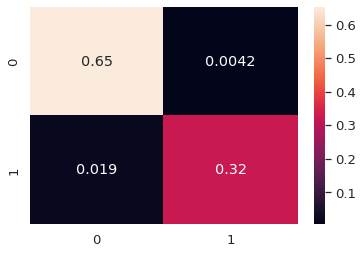

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, neigh.predict(X_train))
sns.heatmap(cm/np.sum(cm), annot=True)

In [ ]:
np.array(y)

array([[  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       ...,
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.]])

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(X), np.array(y), test_size = 0.25)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1654, 60), (1654, 5), (551, 60), (551, 5))

In [ ]:
from sklearn.multioutput import MultiOutputClassifier

neigh = KNeighborsClassifier(n_neighbors=1)
classifier = MultiOutputClassifier(neigh, n_jobs=-1)
classifier.fit(X_train,y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=1), n_jobs=-1)

In [ ]:
classifier.score(X_train,y_train)

1.0

# OFF

In [ ]:
ps1[:3]

array([[151.47, 151.45, 151.52, ..., 151.1 , 151.21, 151.19],
       [151.11, 151.12, 151.16, ..., 150.79, 150.8 , 150.86],
       [150.81, 150.79, 150.84, ..., 150.43, 150.54, 150.62]])

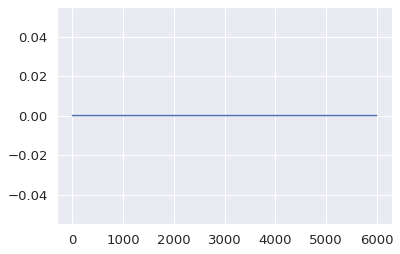

In [ ]:
plt.plot(new_df['PS4'][0])

TODO: function to generate all graphs for a single sample, to presentation purposes

In [ ]:
from sktime.datatypes._panel._convert import from_nested_to_2d_array

def extract(col, dest_df):
    unnested = from_nested_to_2d_array(new_df[col])
    dest_df[col+"_mean"] = unnested.mean(axis=1)
    dest_df[col+"_min"] = unnested.min(axis=1)
    dest_df[col+"_max"] = unnested.max(axis=1)
    dest_df[col+"_std"] = unnested.std(axis=1)

In [ ]:
extracted_df = pd.DataFrame()
for col in new_df.columns:
    extract(col, extracted_df)

In [ ]:
extracted_df.head()

,PS4_mean,PS4_min,PS4_max,PS4_std,PS1_mean,PS1_min,PS1_max,PS1_std,PS2_mean,PS2_min,...,TS4_max,TS4_std,TS2_mean,TS2_min,TS2_max,TS2_std,VS1_mean,VS1_min,VS1_max,VS1_std
0,0.0,0.0,0.0,0.0,160.673492,145.83,191.51,13.939309,109.466914,0.0,...,33.594,1.116478,40.978767,40.773,41.250,0.154302,0.576950,0.532,0.624,0.027078
1,0.0,0.0,0.0,0.0,160.603320,145.73,191.47,14.118967,109.354890,0.0,...,35.148,0.435312,41.532767,41.031,42.105,0.338234,0.565850,0.524,0.626,0.027241
2,0.0,0.0,0.0,0.0,160.347720,145.37,191.41,14.192619,109.158845,0.0,...,36.141,0.293889,42.442450,41.832,43.039,0.390588,0.576533,0.529,0.662,0.036729
3,0.0,0.0,0.0,0.0,160.188088,145.14,191.34,14.227803,109.064807,0.0,...,36.988,0.262397,43.403983,42.805,43.988,0.398476,0.569267,0.527,0.645,0.033464
4,0.0,0.0,0.0,0.0,160.000472,144.95,191.41,14.276434,108.931434,0.0,...,37.781,0.239571,44.332750,43.742,44.887,0.372769,0.577367,0.524,0.660,0.033484


In [ ]:
nested.std(axis=1)

0       13.939309
1       14.118967
2       14.192619
3       14.227803
4       14.276434
          ...    
2200    13.987129
2201    14.001418
2202    13.988350
2203    13.985248
2204    13.984674
Length: 2205, dtype: float64

In [ ]:
nested

,PS1__0,PS1__1,PS1__2,PS1__3,PS1__4,PS1__5,PS1__6,PS1__7,PS1__8,PS1__9,...,PS1__5990,PS1__5991,PS1__5992,PS1__5993,PS1__5994,PS1__5995,PS1__5996,PS1__5997,PS1__5998,PS1__5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,151.16,151.19,151.25,151.16,151.10,151.16,151.14,151.10,151.21,151.19
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,150.82,150.82,150.86,150.80,150.73,150.79,150.84,150.79,150.80,150.86
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,150.49,150.44,150.47,150.46,150.38,150.47,150.50,150.43,150.54,150.62
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,150.34,150.30,150.28,150.38,150.41,150.33,150.31,150.31,150.25,150.28
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,150.31,150.20,150.17,150.28,150.31,150.25,150.27,150.22,150.13,150.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,151.70,151.83,151.90,151.75,151.62,151.63,153.78,154.73,153.83,154.43,...,151.84,151.75,151.67,151.76,151.81,151.78,151.78,151.83,151.84,151.86
2201,151.90,151.83,151.81,151.77,151.65,151.63,153.97,154.84,153.67,154.37,...,151.81,151.81,151.84,151.83,151.79,151.87,151.87,151.75,151.77,151.78
2202,151.73,151.78,151.84,151.62,151.46,151.49,153.91,154.88,153.69,154.24,...,151.73,151.66,151.73,151.71,151.68,151.79,151.84,151.73,151.73,151.83
2203,151.77,151.77,151.75,151.56,151.47,151.57,154.09,154.80,153.45,154.21,...,151.75,151.71,151.68,151.71,151.73,151.75,151.71,151.68,151.71,151.78


In [ ]:
#

In [ ]:
nested = from_2d_array_to_nested(ps1)

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
settings = MinimalFCParameters()
t = TSFreshFeatureExtractor(default_fc_parameters=settings, n_jobs=-1)

In [ ]:
# ~3min to transform minimimally only PS1
Xt = t.fit_transform(nested)
Xt.head()

Feature Extraction: 100%|██████████| 2205/2205 [00:04<00:00, 453.77it/s]


,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
0,964040.95,156.25,160.673492,6000.0,13.938147,194.271939,161.276914,191.51,191.51,145.83
1,963619.92,156.06,160.603320,6000.0,14.117791,199.312019,161.222636,191.47,191.47,145.73
2,962086.32,155.72,160.347720,6000.0,14.191436,201.396849,160.974495,191.41,191.41,145.37
3,961128.53,155.56,160.188088,6000.0,14.226617,202.396639,160.818594,191.34,191.34,145.14
4,960002.83,155.34,160.000472,6000.0,14.275244,203.782600,160.636028,191.41,191.41,144.95


In [ ]:
Xt.shape

(2205, 10)

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
settings = MinimalFCParameters()
t = TSFreshFeatureExtractor(default_fc_parameters=settings, n_jobs=-1)

In [ ]:
Xt = t.fit_transform(nested)
Xt.head()

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
0,964040.95,156.25,160.673492,6000.0,13.938147,194.271939,161.276914,191.51,191.51,145.83
1,963619.92,156.06,160.603320,6000.0,14.117791,199.312019,161.222636,191.47,191.47,145.73
2,962086.32,155.72,160.347720,6000.0,14.191436,201.396849,160.974495,191.41,191.41,145.37
3,961128.53,155.56,160.188088,6000.0,14.226617,202.396639,160.818594,191.34,191.34,145.14
4,960002.83,155.34,160.000472,6000.0,14.275244,203.782600,160.636028,191.41,191.41,144.95


In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
settings = MinimalFCParameters()
t = TSFreshFeatureExtractor(default_fc_parameters=settings, n_jobs=-1)

In [ ]:
Xt = t.fit_transform(new_df)
Xt.head()

In [ ]:
target = np.genfromtxt("profile.txt")

df_temp=pd.DataFrame(target,columns=["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"])
df_temp.shape

(2205, 5)

In [ ]:
df_temp.head()

,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,3.0,100.0,0.0,130.0,1.0
1,3.0,100.0,0.0,130.0,1.0
2,3.0,100.0,0.0,130.0,1.0
3,3.0,100.0,0.0,130.0,1.0
4,3.0,100.0,0.0,130.0,1.0


In [ ]:
def load_cycle()